In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as pl

from __future__ import print_function
import sys
import matplotlib.pylab as pl
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM

Populating the interactive namespace from numpy and matplotlib


In [2]:
!for ((y=93; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-12 22:59:23--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp93totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-12-12 22:59:23 ERROR 404: Not Found.

--2017-12-12 22:59:23--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip.5”

100%[======================================>] 611,524     --.-K/s   in 0.04s   

2017-12-12 22:59:24 (16.5 MB/s) - “zbp94totals.zip.5” saved [611524/611524]

--2017-12-12 22:59:24--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp95totals.zip
Resolving www2.census.gov

Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: “zbp09totals.zip.4”

100%[======================================>] 660,109     --.-K/s   in 0.06s   

2017-12-12 22:59:26 (11.1 MB/s) - “zbp09totals.zip.4” saved [660109/660109]

--2017-12-12 22:59:26--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip.4”

100%[======================================>] 797,534     --.-K/s   in 0.02s   

2017-12-12 22:59:26 (37.3 MB/s) - “zbp10totals.zip.4” saved [797534/797534]

--2017-12-12 22:59:26--  https://www2.census.gov

In [3]:
PUIdata = os.getenv('PUIDATA')

In [48]:
ts_df = pd.DataFrame()

In [49]:
for i in range(94,100):
    fname='zbp' + str(i) + 'totals.zip'
    time = 1900 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)

In [50]:
for i in range(0,15):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    time = 2000 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)

In [51]:
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
urllib.urlretrieve(url, 'NYCZIP.zip')
os.system('unzip NYCZIP.zip -d ' + PUIdata + '/NYCZIP')

256

In [52]:
# locate .shp file
for fname in os.listdir(os.getenv('PUIDATA') + '/NYCZIP'):
    if fname.endswith('shp'):
        shpfile = fname

# read in shapefile
zipshp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/NYCZIP/' + shpfile)
print(zipshp.crs)
zipshp.head()

{u'lon_0': -74, u'datum': u'NAD83', u'y_0': 0, u'no_defs': True, u'proj': u'lcc', u'x_0': 300000, u'units': u'us-ft', u'lat_2': 41.03333333333333, u'lat_1': 40.66666666666666, u'lat_0': 40.16666666666666}


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [53]:
zipshp = zipshp[['ZIPCODE', 'geometry']]
zipshp['ZIPCODE'] = pd.to_numeric(zipshp['ZIPCODE'])
zipshp.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [54]:
ts_df.head()

,ZIP,EST,YEAR
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


In [55]:
ts_df = pd.pivot_table(ts_df, values='EST', index='ZIP', columns='YEAR' )
ts_df.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,7.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [56]:
ts_df.dropna(axis = 0, inplace = True)
ts_df.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,21.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
1005,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,93.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [122]:
df = ts_df.merge(zipshp, right_on = 'ZIPCODE', left_index = True)
df.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,ZIPCODE,geometry
82,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0,10001,"POLYGON ((981958.6472873986 213464.4530421346,..."
92,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0,10002,"POLYGON ((991339.8703228086 207576.7837151289,..."
90,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0,10003,"POLYGON ((989830.469142139 207048.1263078749, ..."
106,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004,"POLYGON ((981197.408652395 196571.0816452205, ..."
109,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004,"POLYGON ((972696.8446168154 193014.5477478057,..."


In [123]:
df.shape

(243, 23)

In [124]:
df.drop('geometry', axis=1, inplace=True)

In [125]:
df.set_index('ZIPCODE', inplace = True)
df.head

<bound method DataFrame.head of YEAR       1994    1995    1996    1997    1998    1999    2000    2001  \
ZIPCODE                                                                   
10001    6999.0  7088.0  7075.0  7154.0  7254.0  7233.0  7317.0  7188.0   
10002    1784.0  1819.0  1919.0  2049.0  2003.0  2085.0  2277.0  2543.0   
10003    3256.0  3377.0  3417.0  3535.0  3649.0  3659.0  3683.0  3602.0   
10004    1115.0  1124.0  1133.0  1173.0  1176.0  1233.0  1294.0  1247.0   
10004    1115.0  1124.0  1133.0  1173.0  1176.0  1233.0  1294.0  1247.0   
10004    1115.0  1124.0  1133.0  1173.0  1176.0  1233.0  1294.0  1247.0   
10004    1115.0  1124.0  1133.0  1173.0  1176.0  1233.0  1294.0  1247.0   
10005    1076.0  1109.0  1216.0  1227.0  1270.0  1242.0  1287.0  1249.0   
10006    1061.0  1002.0   969.0   990.0  1030.0  1059.0  1067.0  1026.0   
10007    1307.0  1274.0  1254.0  1287.0  1282.0  1303.0  1327.0  1233.0   
10009     634.0   633.0   673.0   747.0   786.0   804.0   860.0   86

In [126]:
df.shape

(243, 21)

In [127]:
std_df = ((df.T - df.mean(axis=1)) / df.std(axis=1)).T
std_df.shape

(243, 21)

In [128]:
for j in range(0,10):
    st = std_df.iloc[j]
    print("STD for ZIP {} is {:.2f}".format(st.name, st.std()))
    print("MEAN for ZIP {} is {:.2f}".format(st.name, st.mean()))

STD for ZIP 10001 is 1.00
MEAN for ZIP 10001 is -0.00
STD for ZIP 10002 is 1.00
MEAN for ZIP 10002 is 0.00
STD for ZIP 10003 is 1.00
MEAN for ZIP 10003 is -0.00
STD for ZIP 10004 is 1.00
MEAN for ZIP 10004 is -0.00
STD for ZIP 10004 is 1.00
MEAN for ZIP 10004 is -0.00
STD for ZIP 10004 is 1.00
MEAN for ZIP 10004 is -0.00
STD for ZIP 10004 is 1.00
MEAN for ZIP 10004 is -0.00
STD for ZIP 10005 is 1.00
MEAN for ZIP 10005 is -0.00
STD for ZIP 10006 is 1.00
MEAN for ZIP 10006 is 0.00
STD for ZIP 10007 is 1.00
MEAN for ZIP 10007 is -0.00


In [129]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k, random_state=123).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.572142801777
For n_clusters = 3 The average silhouette_score is : 0.539682170913
For n_clusters = 4 The average silhouette_score is : 0.49394124643
For n_clusters = 5 The average silhouette_score is : 0.336185242399
For n_clusters = 6 The average silhouette_score is : 0.237073557701
For n_clusters = 7 The average silhouette_score is : 0.278464729872
For n_clusters = 8 The average silhouette_score is : 0.196453757275
For n_clusters = 9 The average silhouette_score is : 0.233020218107
For n_clusters = 10 The average silhouette_score is : 0.217045952677


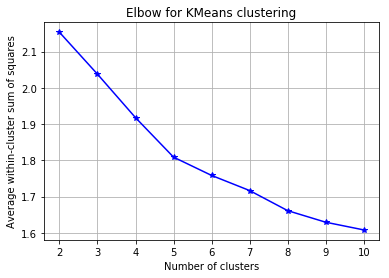

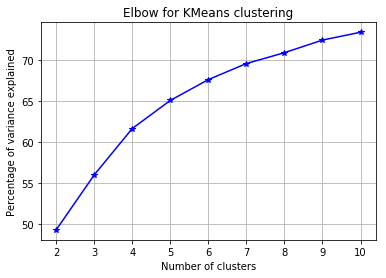

In [130]:
# CODE FROM ADS LAB

range_n_clusters = range(2,11)
for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(std_df)
    silhouette_avg = silhouette_score(std_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(std_df, cluster_labels)
elbow(std_df,range_n_clusters)

## Figure 1. Elbow for Kmeans clustering for business per zip code
Elbow shows a slight turn at n = 5, therefore clustering = 5.

In [131]:
#Kmeans
n = 5
km = KMeans(n_clusters=n)
km_res = km.fit(std_df)

In [132]:
#Hierarchical
n = 5
agc = AgglomerativeClustering(n_clusters=n,  compute_full_tree=True)
agc_res = agc.fit(std_df)

In [133]:
std_df['KLABEL'] = km_res.labels_
std_df['AGCLABEL'] = agc_res.labels_

In [134]:
centersKM = pd.DataFrame(km_res.cluster_centers_)
centersKM.columns = std_df.columns[:-2]
centersKM.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.971268,-1.644603,-1.332356,-0.939056,-0.762030,-0.535592,-0.385281,-0.397102,-0.066144,0.123870,...,0.527432,0.610915,0.649348,0.631498,0.636741,0.715627,0.809472,0.830151,0.951287,1.144117
1,-1.213420,-1.170640,-1.110719,-0.998478,-0.912306,-0.873310,-0.761482,-0.663986,-0.331332,-0.203697,...,0.084677,0.138280,0.354036,0.488353,0.619838,0.878380,1.045795,1.305996,1.572905,1.798265
2,1.397133,0.960669,0.493329,0.087909,-0.054033,0.221152,-0.128385,-0.279826,-0.759866,-0.963258,...,-0.502322,-0.591225,-0.205437,-0.254533,-0.068702,0.020319,0.036318,0.317039,0.293528,0.625920
3,0.111768,0.506884,0.724867,0.899727,1.009363,1.055068,1.169734,0.875529,0.137188,0.102524,...,0.000737,0.007255,-0.381629,-0.510684,-0.621264,-0.871843,-1.008051,-1.101585,-1.111203,-1.105419
4,-0.940495,-0.844224,-0.712416,-0.378653,-0.298608,-0.207286,0.309707,0.537699,0.800678,0.880751,...,0.833242,0.520268,0.186618,-0.109121,-0.468407,-0.540096,-0.819274,-0.433498,0.023420,0.093902


In [135]:
geo_cluster = zipshp.merge(std_df[['KLABEL', 'AGCLABEL']], left_on='ZIPCODE', right_index=True)

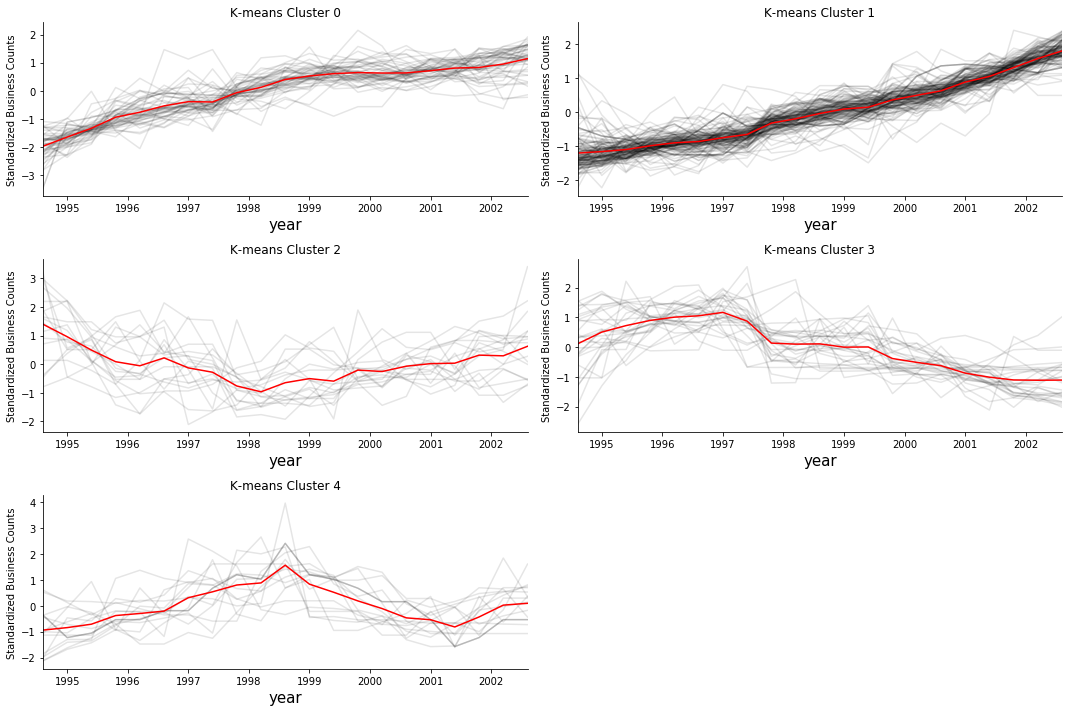

In [136]:
fig = pl.figure(figsize=(15,10))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = std_df[std_df['KLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    ax.plot(centersKM.iloc[k], c='r')
    ax.set_xticklabels(cluster.columns[:-2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('year', fontsize=15)
    ax.set_ylabel('Standardized Business Counts', fontsize=10)
    ax.set_xlim([1994,2014])
    ax.set_title("K-means Cluster {}".format(str(k)))
    
pl.tight_layout()
pl.show()

## Figure 2. KMeans Clustering of business data per zipcode
The gray lines present the standardized number of businesses per ZIP Code while the red line is the center (mean) of all the time series in the cluster. There is a big group of ZIP codes in cluster 0.

In [137]:
agc_centers = pd.DataFrame()

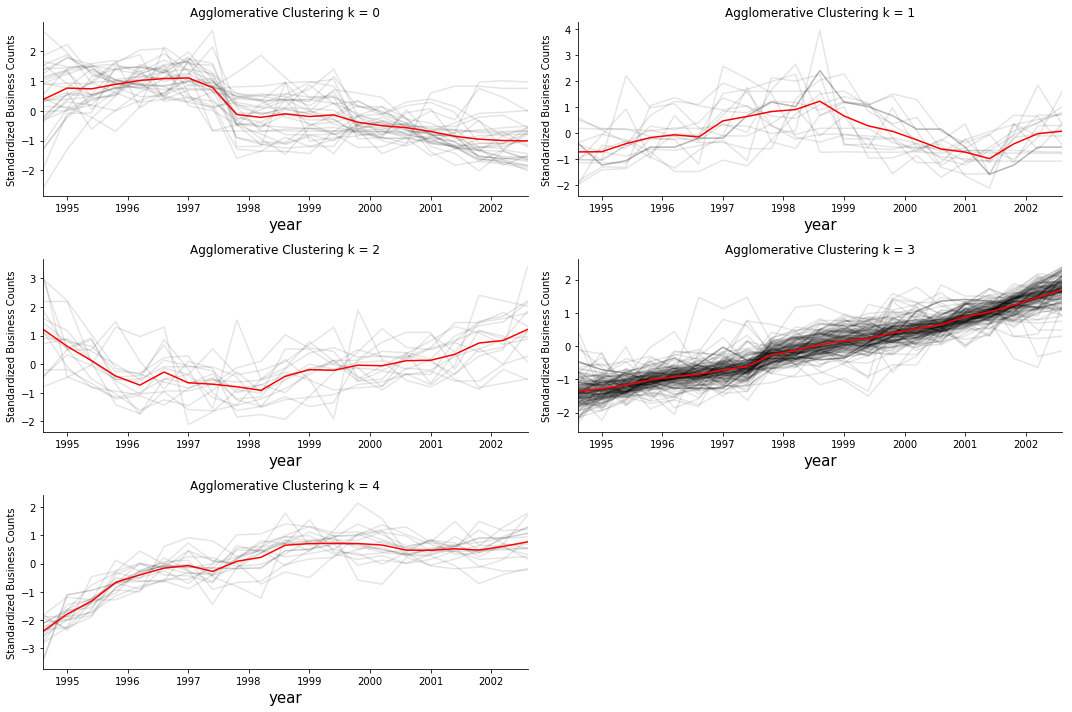

In [138]:
fig = pl.figure(figsize=(15,10))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = std_df[std_df['AGCLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    agc_centers = agc_centers.append(cluster.iloc[:,:-2].mean(),ignore_index=True)
    ax.plot(cluster.iloc[:,:-2].mean(), c='r')
    ax.set_xticklabels(cluster.columns[:-2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('year', fontsize=15)
    ax.set_ylabel('Standardized Business Counts', fontsize=10)
    ax.set_xlim([1994,2014])
    ax.set_title("Agglomerative Clustering k = {}".format(str(k)))
    
pl.tight_layout()
pl.show()

## Figure 3. Hierarchical agglomerative Clustering of the Business Trend per ZIP Code in NYC
shows a similarility to Figure 2

In [139]:
agc_centers.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.375351,0.762755,0.736535,0.890028,1.019741,1.081348,1.104287,0.782074,-0.124248,-0.221498,...,-0.193206,-0.137930,-0.384032,-0.502805,-0.566787,-0.694868,-0.856635,-0.954452,-0.999948,-1.012417
1,-0.719188,-0.711710,-0.400728,-0.169742,-0.059524,-0.144779,0.476144,0.645124,0.835279,0.911482,...,0.665260,0.282476,0.075125,-0.253356,-0.608228,-0.727297,-0.977740,-0.413188,-0.015574,0.076448
2,1.222823,0.625098,0.126723,-0.410517,-0.728822,-0.273983,-0.647794,-0.697427,-0.786204,-0.911704,...,-0.186600,-0.213269,-0.033127,-0.054216,0.123486,0.137257,0.345760,0.740434,0.830372,1.214154
3,-1.356652,-1.280391,-1.168695,-1.017336,-0.917790,-0.844562,-0.718429,-0.613851,-0.270899,-0.121914,...,0.161353,0.222095,0.405476,0.519907,0.648064,0.880712,1.029541,1.230234,1.472022,1.697908
4,-2.408928,-1.793865,-1.338765,-0.665638,-0.402575,-0.159936,-0.068427,-0.276676,0.082869,0.224138,...,0.712014,0.723522,0.714169,0.658969,0.479755,0.473111,0.526670,0.481544,0.612338,0.771575


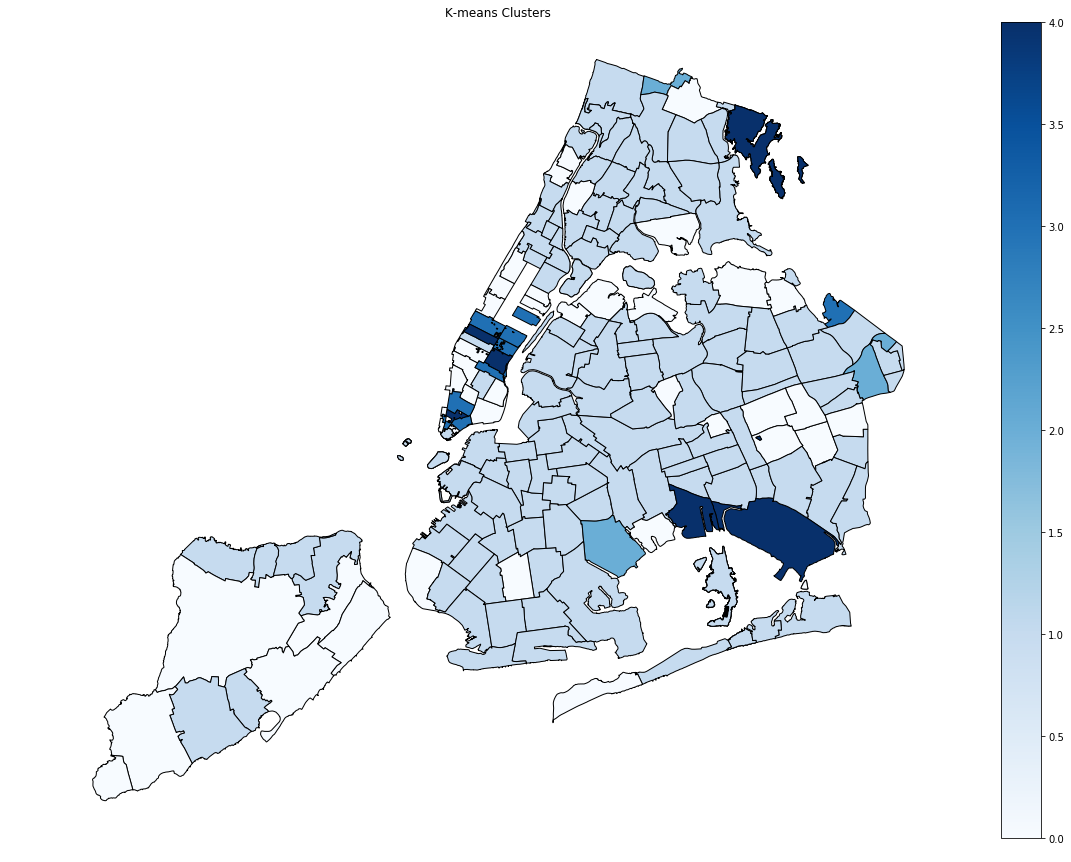

In [140]:
fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='KLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('K-means Clusters')
ax2.axis('off');

## Figure 4. Geographic Representation of K-means Clustering of Business data (n = 5)
Each color signifies one cluster and as seen from the time series clusters in Figure 2, a lot of areas are clustered together. We can see that areas in the Midtown and Downtown Manhattan have a number of ZIP code areas next to each other clustered in the same group.

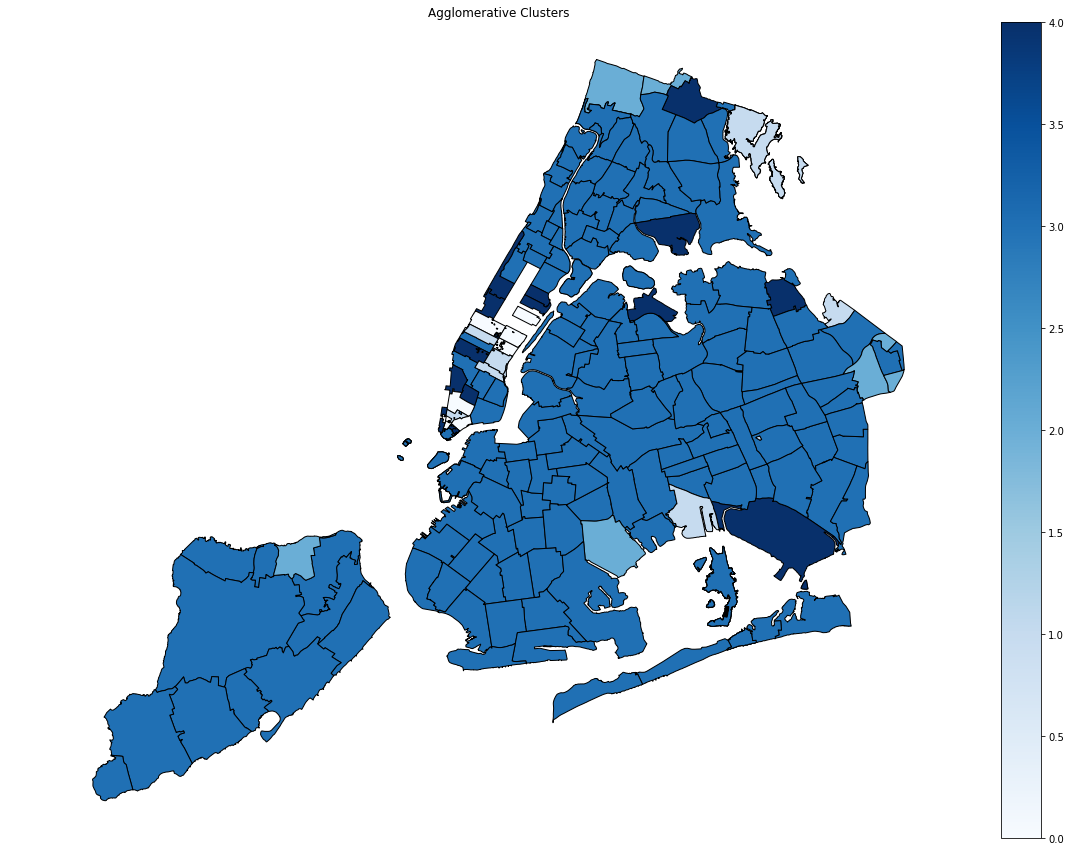

In [141]:
fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='AGCLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('Agglomerative Clusters')
ax2.axis('off');

## Figure 5. Geographic Representation of Agglomerative Clustering of Business Data (n = 5)
Similar to Figure 4, each color signifies one cluster. Here we can see the KMeans and Agglomerative clustering are very different. In the K-means clustering, we saw there were 2 ZIP code areas in Staten Island which are in different clusters, but here we only see one ZIP code in Staten Island in a different cluster as the rest of the borough.

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage

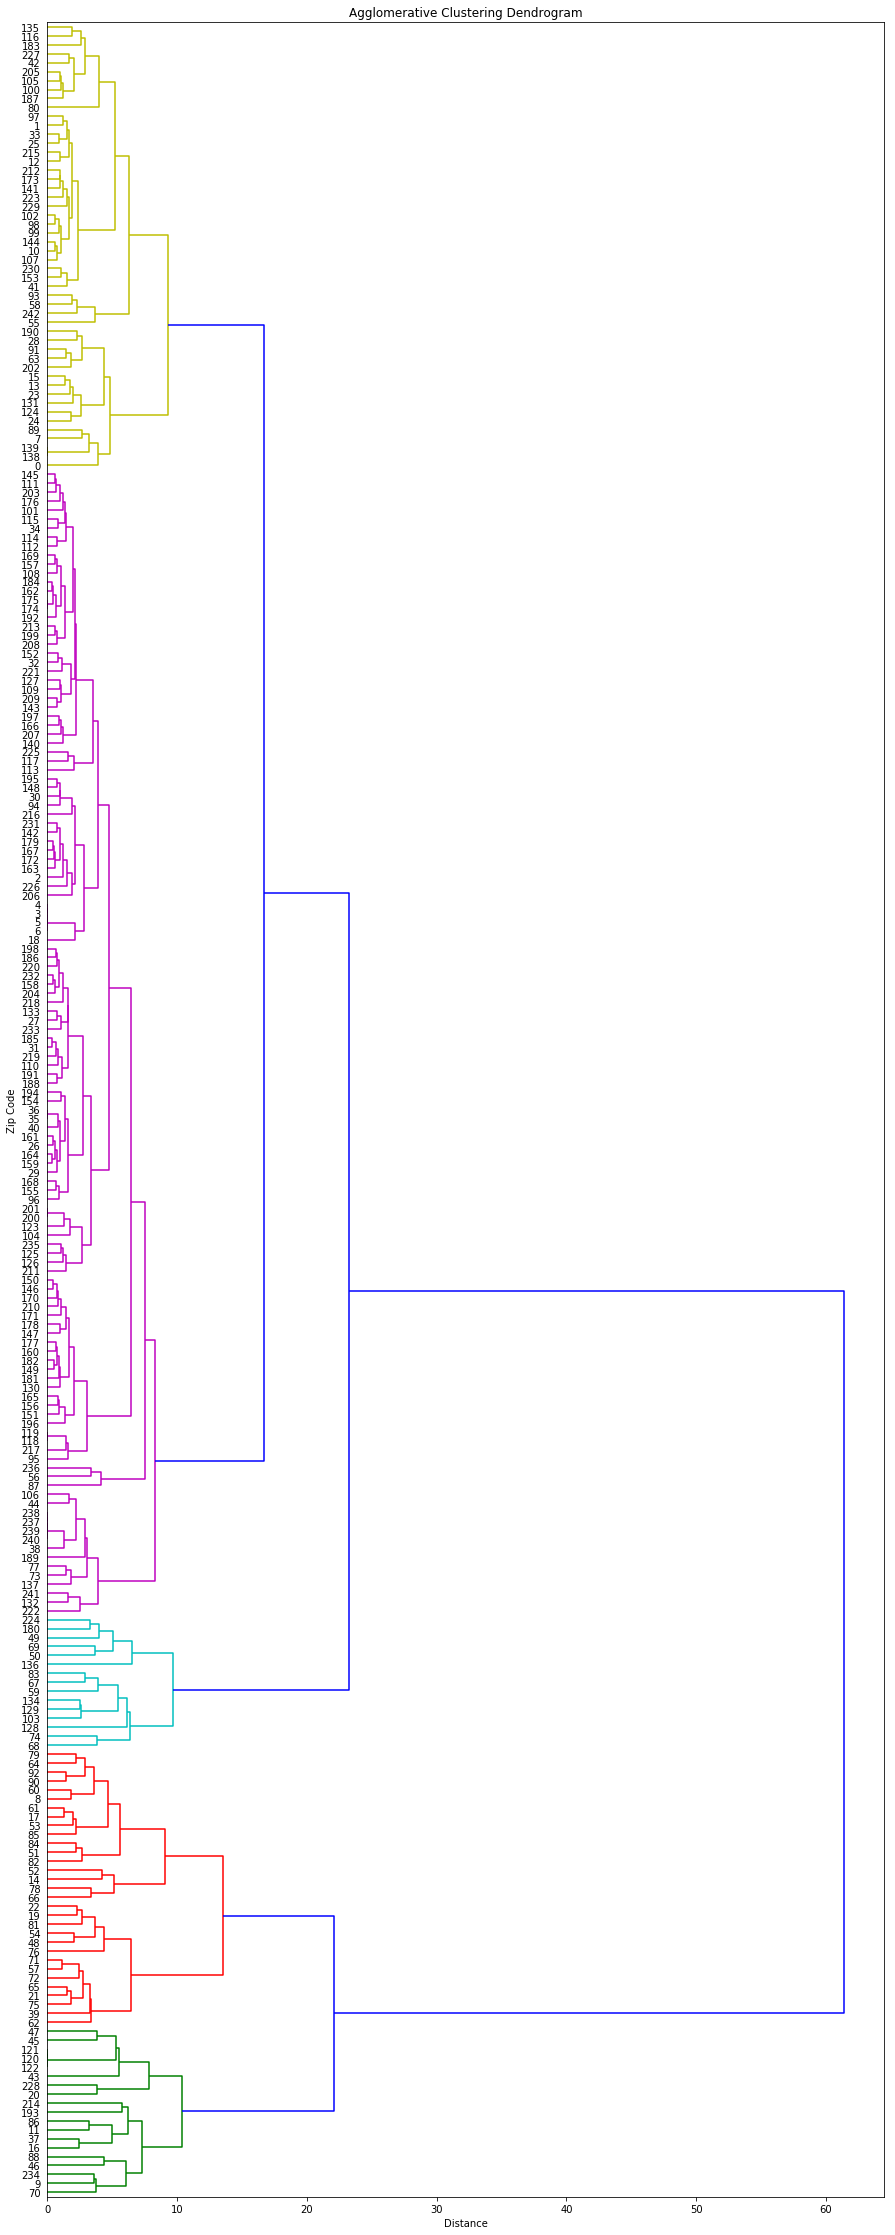

In [150]:
plt.figure(figsize=(15, 40))
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Zip Code')
dendrogram(
    linkage(std_df, 'ward'),
    leaf_font_size=10.,
    orientation='right',
    color_threshold=15
);

## Figure 6. Agglomerative Clustering Dendrogram. 
The dendrogram indicates that agglomerative Clustering is a "bottom up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy. There is one group with a large majority of the samples and the rest having a smaller count.